In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Model
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2

In [2]:
data = pd.read_csv(r'C:\Users\ciara\Downloads\fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
pixel_data = data['pixels']
label_data = data['emotion']

In [4]:
def preprocess_pixels(pixel_data):
  images = []
  for i in range(len(pixel_data)):
    img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
    img = img.reshape(48,48,1)
    images.append(img)
  X = np.array(images)
  return X

In [5]:
oversampler = RandomOverSampler(sampling_strategy='auto')
X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1, 1), label_data)
X_over_series = pd.Series(X_over.flatten())

In [6]:
X = preprocess_pixels(X_over_series)
Y = Y_over

In [7]:
Y_over.values.reshape(Y.shape[0],1)
Y.shape

(62923,)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.1, random_state= 45)

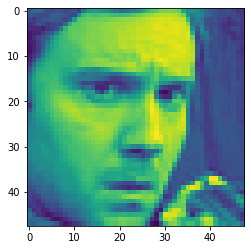

In [9]:
plt.imshow(X[0, :, :, 0])

In [10]:
def emotion_recognition(input_shape):

  X_input = Input(input_shape)
  X = Conv2D(32, kernel_size = (3,3), strides = (1,1), padding='valid')(X_input)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)



  X = Conv2D(64, kernel_size = (3,3), strides = (1,1), padding='same')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)


  X = MaxPooling2D((2,2))(X)

  X = Conv2D(64, kernel_size = (3,3), strides = (1,1), padding='valid')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  X = Conv2D(128, kernel_size = (3,3), strides = (1,1), padding='same')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)


  X = MaxPooling2D((2,2))(X)


  X = Conv2D(128, kernel_size = (3,3), strides = (1,1), padding='valid')(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)


  X = MaxPooling2D((2,2))(X)
  X = Flatten()(X)
  X = Dense(200, activation = 'relu')(X)

  X = Dropout(0.6)(X)
  X = Dense(7, activation = 'softmax')(X)

  model = Model(inputs = X_input, outputs = X)


  return model

In [11]:
model = emotion_recognition((48,48,1))

In [12]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
y_train = to_categorical(Y_train, num_classes = 7)

y_test = to_categorical(Y_test, num_classes = 7)

In [14]:
model.fit(X_train, y_train, epochs = 30, validation_data = (X_test, y_test))

Epoch 1/30
1770/1770 [==============================] - 958s 539ms/step - loss: 1.7319 - accuracy: 0.3253 - val_loss: 1.4215 - val_accuracy: 0.4799
Epoch 2/30
1770/1770 [==============================] - 979s 553ms/step - loss: 1.3772 - accuracy: 0.4741 - val_loss: 1.1746 - val_accuracy: 0.5582
Epoch 3/30
1770/1770 [==============================] - 996s 562ms/step - loss: 1.2007 - accuracy: 0.5392 - val_loss: 1.0802 - val_accuracy: 0.5875
Epoch 4/30
1770/1770 [==============================] - 969s 548ms/step - loss: 1.0828 - accuracy: 0.5855 - val_loss: 1.0076 - val_accuracy: 0.6216
Epoch 5/30
1770/1770 [==============================] - 999s 565ms/step - loss: 0.9948 - accuracy: 0.6183 - val_loss: 0.9720 - val_accuracy: 0.6239
Epoch 6/30
1770/1770 [==============================] - 970s 548ms/step - loss: 0.9145 - accuracy: 0.6524 - val_loss: 0.9041 - val_accuracy: 0.6537
Epoch 7/30
1770/1770 [==============================] - 977s 552ms/step - loss: 0.8393 - accuracy: 0.6810 - val_

In [15]:
model.evaluate(X_test, y_test)

197/197 [==============================] - 30s 146ms/step - loss: 0.8675 - accuracy: 0.8339


[0.8675048351287842, 0.8339424729347229]

In [16]:
preds = model.predict(X_train)
def get_class(preds):
    pred_class = np.zeros((preds.shape[0],1))
    for i in range(len(preds)):
        pred_class[i] = np.argmax(preds[i])
        
    return pred_class

pred_class_train = get_class(preds)

In [17]:
train_report  = classification_report(Y_train, pred_class_train)
print(train_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8054
           1       1.00      1.00      1.00      8094
           2       0.99      0.98      0.98      8109
           3       1.00      0.99      0.99      8083
           4       0.96      0.99      0.98      8101
           5       0.99      0.99      0.99      8120
           6       0.99      0.98      0.99      8069

    accuracy                           0.99     56630
   macro avg       0.99      0.99      0.99     56630
weighted avg       0.99      0.99      0.99     56630



In [18]:
test_preds = model.predict(X_test)
len(test_preds)

6293

In [19]:
pred_test_class = get_class(test_preds)
report_test = classification_report(Y_test, pred_test_class)
print(report_test)

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       935
           1       1.00      1.00      1.00       895
           2       0.81      0.80      0.80       880
           3       0.85      0.74      0.79       906
           4       0.65      0.82      0.73       888
           5       0.94      0.92      0.93       869
           6       0.80      0.74      0.77       920

    accuracy                           0.83      6293
   macro avg       0.84      0.83      0.84      6293
weighted avg       0.84      0.83      0.84      6293



In [20]:
label_dict = {0: "Angry", 1: "Disguist", 2: "Fear", 3: "Happiness", 4: "Sad", 5: "Suprise", 6: "Neutral"}

In [26]:
img_path = "test_happiness.jfif"
img = image.load_img(img_path, grayscale=True, target_size=(48,48))

In [27]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x.shape

(1, 48, 48, 1)

The predicted emotion is: Fear


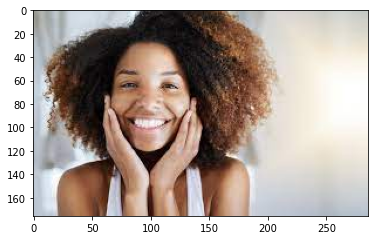

In [29]:
prediction = np.argmax(model.predict(x))
print("The predicted emotion is: " + label_dict[prediction])
my_image = image.load_img(img_path)
plt.imshow(my_image)

The predicted emotion is: Sad


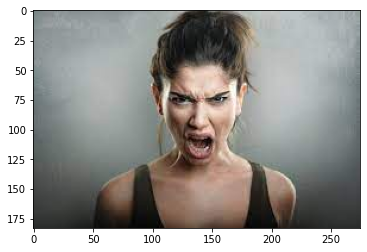

In [24]:
img_path = "angryyy.jfif"
img = image.load_img(img_path, grayscale=True, target_size=(48,48))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x.shape
prediction = np.argmax(model.predict(x))
print("The predicted emotion is: " + label_dict[prediction])
my_image = image.load_img(img_path)
plt.imshow(my_image)

In [54]:
face_haar_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [74]:
cap = cv2.VideoCapture(0)

while True:
 
 _,cap_image = cap.read()




 cap_img_gray = cv2.cvtColor(cap_image, cv2.COLOR_BGR2GRAY)

 faces = face_haar_cascade.detectMultiScale(cap_img_gray, 1.3, 5)

 for (x,y,w,h) in faces:

   cv2.rectangle(cap_image, (x,y), (x+w,y+h),(255,0,0),2)
   roi_gray = cap_img_gray[y:y+h, x:x+w]
   roi_gray = cv2.resize(roi_gray, (48,48))
   img_pixels = image.img_to_array(roi_gray)
   img_pixels = np.expand_dims(img_pixels, axis=0)

   predictions = model.predict(img_pixels)
   emotion_label = np.argmax(predictions)

   emotion_prediction = label_dict[emotion_label]

   cv2.putText(cap_image, emotion_prediction, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1 )

   resize_image = cv2.resize(cap_image, (1000,700))
   cv2.imshow('Emotion',resize_image)

   if cv2.waitKey(10) == ord('b'):
    break
  
cap.release()
cv2.destroyAllWindows 
            

error: OpenCV(4.5.4) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'
